In [1]:
%matplotlib inline
import gym
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import deque
from IPython import display
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from scipy import stats
from training_methods import *
%load_ext autoreload
%autoreload

In [2]:
def show(env, agent, params, frames, width, height, greedy=True):
#     img = plt.imshow(env.render(mode='rgb_array'))
    state = env_reset(env)
    img = plt.imshow(state.reshape(width, height))
    frame = 0
    for _ in range(frames):
#         img.set_data(env.render(mode='rgb_array'))
        img.set_data(state.reshape(width, height))
        display.display(plt.gcf())
        display.clear_output(wait=True)

        action = agent.act_greedy(state, frame) if greedy else np.random.randint(0, params.action_size)
        state, reward, done, _ = env_step(env, action)
        if done:
            state = env_reset(env)
            frame = 0
        else:
            frame += 1

In [3]:
class LearningParameters:
    def __init__(self, env, episodes_count):
        state = env_reset(env)

        self.state_shape = state.shape
        self.state_size = np.prod(self.state_shape)
        self.action_size = env.action_space.n
        self.episodes_count = episodes_count
        self.max_frame_in_episode = env.spec.max_episode_steps
        self.max_memory_size = 10000
        self.episodes_between_think = 1
        
        self.gamma = 0.95                # discount rate
        self.epsilon = 1.0               # exploration rate
        self.epsilon_start = self.epsilon
        self.epsilon_min = 0.0001        # min exploration rate
        self.learning_rate = 0.1         # learning rate for algorithm
        self.learning_rate_model = 0.01  # learning rate for model
        
        print("State shape {}, actions {}".format(self.state_shape, self.action_size))

    def decay_exploration_rate(self, episode):
        # Linear exploration rate decay (lerp)
#         self.epsilon = self.epsilon_start - \
#                       (self.epsilon_start - self.epsilon_min) * (float(frame) / self.frames_count)
            
        # Exponential rate decay
        # y(0) = start
        # y(1) = start * x
        # y(2) = start * x^2
        # y(steps) = start * x^steps = min => x = (min/start) ^ (1/steps)
        # y(t) = start * x^t
        self.epsilon = self.epsilon_start * \
                       math.pow( math.pow(self.epsilon_min / self.epsilon_start, 1.0 / self.episodes_count), episode )

## Action is added to input as OHE

In [4]:
class ActionAsInputAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()
        
    def _build_model(self):
        input_len = self.params.state_size + self.params.action_size

        x = tf.placeholder("float", [None, input_len], name="Placeholder_x")
        y = tf.placeholder("float", [None, 1], name="Placeholder_y")
        
        w0 = tf.Variable(tf.random_normal([input_len, 20]))
        b0 = tf.Variable(tf.random_normal([20]))
        w1 = tf.Variable(tf.random_normal([20, 1]))
        b1 = tf.Variable(tf.random_normal([1]))
        
        h0 = tf.add(tf.matmul(x, w0), b0)
        h0 = tf.nn.relu(h0)
        
        pred = tf.add(tf.matmul(h0, w1), b1)
        
        cost = tf.nn.l2_loss(pred - y)
        train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99).minimize(cost)
        
        init = tf.global_variables_initializer()
        
        return {
            'x': x,
            'y': y,
            'pred': pred,
            'cost': cost,
            'train_op': train_op,
            'init': init
        }

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state, frame))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        x = self.model['x']
        pred = self.model['pred']

        X = np.resize(state, (1, self.params.state_size + self.params.action_size))
        X[0, self.params.state_size:] = 0
        
        rewards = np.zeros((self.params.action_size))
        for i in range(self.params.action_size):
            X[0, self.params.state_size + i] = 1
            rewards[i] = session.run(pred, {x: X})[0]
            X[0, self.params.state_size + i] = 0
        return np.argmax(rewards)
    
    def think(self, batch_size):
        x = self.model['x']
        y = self.model['y']
        pred = self.model['pred']
        train_op = self.model['train_op']
        cost = self.model['cost']
        
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size + self.params.action_size))
        Y = np.zeros((cnt, 1))
        for i in range(cnt):
            state, action, reward, next_state, frame = self.memory[i]
            inp = np.resize(state, (self.params.state_size + self.params.action_size))
            inp[self.params.state_size:] = 0
            inp[self.params.state_size + action] = 1
            X[i], Y[i] = inp, reward

        for e in range(1):
            P = np.random.permutation(cnt)
            for i in range(0, cnt, batch_size):
                batch_indexes = P[i: i + batch_size]
                batch_x = X[batch_indexes]
                batch_y = Y[batch_indexes]
                _ = session.run(train_op, {x: batch_x, y: batch_y})

## Policy Gradient

Run with `params.episodes_between_think = 1`

Karpathy: https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5

TF interpretation: https://gist.github.com/greydanus/5036f784eec2036252e1990da21eda18

In [5]:
class PolicyGradientAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()

    def _build_model(self):
        x = tf.placeholder("float", [None, self.params.state_size], name='Placeholder_x')
        y = tf.placeholder("float", [None, self.params.action_size], name='Placeholder_y')
        
        w0 = tf.Variable(tf.random_normal([self.params.state_size, 20]))
        b0 = tf.Variable(tf.random_normal([20]))
        w1 = tf.Variable(tf.random_normal([20, self.params.action_size]))
        b1 = tf.Variable(tf.random_normal([self.params.action_size]))
        
        h0 = tf.add(tf.matmul(x, w0), b0)
        h0 = tf.nn.relu(h0)
        
        pred = tf.add(tf.matmul(h0, w1), b1)
#         pred = tf.nn.softmax(pred)
        
        cost = tf.nn.l2_loss(pred - y)

        optimizer = tf.train.RMSPropOptimizer(self.params.learning_rate_model, decay=0.99)
#         optimizer = tf.train.AdamOptimizer(learning_rate=self.params.learning_rate_model)
    
        gradients = optimizer.compute_gradients(cost, var_list=tf.trainable_variables())
        train_op = optimizer.apply_gradients(gradients)
        
        init = tf.global_variables_initializer()
        
        return {
            'x': x,
            'y': y,
            'pred': pred,
            'cost': cost,
            'init': init,
            'train_op': train_op
        }

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        x = self.model['x']
        pred = self.model['pred']
        act_values = session.run(pred, feed_dict={x: [state]})[0]
        return np.argmax(act_values)

    def think(self, batch_size):
        x = self.model['x']
        y = self.model['y']
        pred = self.model['pred']
        train_op = self.model['train_op']
        
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            target = session.run(pred, feed_dict={x: [state]})[0]
            target[action] = reward
            X[i], Y[i] = state, target

        _ = session.run(train_op, {x: X, y: Y})

## DQN Agent

In [6]:
class DqnAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()

    def _build_model(self):
        x = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_x")
        y = tf.placeholder("float", [None, self.params.action_size], name="Placeholder_y")
        
        w0 = tf.Variable(tf.random_normal([self.params.state_size, 20]))
        b0 = tf.Variable(tf.random_normal([20]))
        w1 = tf.Variable(tf.random_normal([20, self.params.action_size]))
        b1 = tf.Variable(tf.random_normal([self.params.action_size]))
        
        h0 = tf.add(tf.matmul(x, w0), b0)
        h0 = tf.nn.relu(h0)
        
        pred = tf.add(tf.matmul(h0, w1), b1)
        
        cost = tf.nn.l2_loss(pred - y)
        train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99).minimize(cost)
#         train_op = tf.train.AdamOptimizer(learning_rate=self.params.learning_rate_model).minimize(cost)
        
        init = tf.global_variables_initializer()
        
        return {
            'x': x,
            'y': y,
            'pred': pred,
            'cost': cost,
            'init': init,
            'train_op': train_op
        }

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        x = self.model['x']
        pred = self.model['pred']
        act_values = session.run(pred, {x: [state]})[0]
        return np.argmax(act_values)

    def think(self, batch_size):
        x = self.model['x']
        y = self.model['y']
        pred = self.model['pred']
        train_op = self.model['train_op']
        cost = self.model['cost']
        
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            target = session.run(pred, {x: [state]})[0]
            target[action] = reward + self.params.gamma * \
                             np.amax(session.run(pred, {x: [next_state]})[0])
            X[i], Y[i] = state, target

        for e in range(1):
            P = np.random.permutation(cnt)
            for i in range(0, cnt, batch_size):
                batch_indexes = P[i: i + batch_size]
                batch_x = X[batch_indexes]
                batch_y = Y[batch_indexes]
                _ = session.run(train_op, {x: batch_x, y: batch_y})

In [7]:
def preprocess_input_pong_v0(I):
    I = I[35:195] # crop
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I = I[::2,::2,0] + I[1::2,::2,0] + I[::2,1::2,0] + I[1::2,1::2,0]
    I = I[::2,::2] + I[1::2,::2] + I[::2,1::2] + I[1::2,1::2]
    I = I[::2,::2] + I[1::2,::2] + I[::2,1::2] + I[1::2,1::2]
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def preprocess_input_breakout_v0(I):
    I = I[35:195, 10:150]  # crop to (160, 140, 3)
    I = (I[:,:,0] + I[:,:,1] + I[:,:,2]) / 3
    I = I[::2,::2] + I[1::2,::2] + I[::2,1::2] + I[1::2,1::2]
    return I.astype(np.float).ravel()

# print(env.spec.max_episode_steps)

# env = gym.make('CartPole-v1')
# env.my_preprocess_input = lambda x: x

# env = gym.make('MountainCar-v0')
# env.my_preprocess_input = lambda x: x

env = gym.make('Breakout-v0')
env.my_preprocess_input = preprocess_input_breakout_v0

# env.render(close=True)
# plt.imshow(env.render('rgb_array'))
print('Actions: {}, Observation space {}, {} parameters'.format(
    env.action_space.n, env.observation_space.shape, np.prod(env.observation_space.shape)))

[2017-07-24 21:47:56,131] Making new env: Breakout-v0


Actions: 4, Observation space (210, 160, 3), 100800 parameters


In [118]:
print(env.spec.max_episode_steps)
state = env.reset()
env.step(1)
# for i in range(10):
#     state, reward, _, _ = env.step(1)
# state, reward, _, _ = env.step(2)
# state, reward, _, _ = env.step(3)
# state, reward, _, _ = env.step(3)
print(state.shape)
print(reward)

10000
(210, 160, 3)
0.0


(5600,)


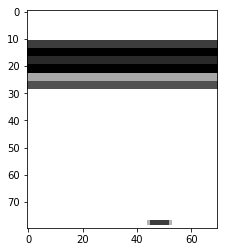

In [8]:
state = env.my_preprocess_input(env.reset())
print(state.shape)
# prepro(state).reshape((80, 80)).shape
plt.imshow(state.reshape((80, 70)), cmap='Greys')
# plt.imshow(env.render('rgb_array'))

In [ ]:
params = LearningParameters(env, episodes_count=500)
params.max_frame_in_episode = min(params.max_frame_in_episode, 500)

# agent = PolicyGradientAgent(params)

agent = DqnAgent(params)

# agent = ActionAsInputAgent(params)

if 'session' in locals():
    session.close()
session = tf.Session()
session.run(agent.model['init'])

agent, rewards = train_discounted_rewards(env, agent, params, normalize_rewards=False)
# agent, rewards = train_reward_is_time(env, agent, params)
# agent, rewards = train(env, agent, params)
plt.plot(rewards)

State shape (5600,), actions 4
episode: 25/500, reward 1.4, frames 311, exploration rate: 0.65
episode: 50/500, reward 1.3, frames 247, exploration rate: 0.41
episode: 75/500, reward 0.7, frames 237, exploration rate: 0.26


In [224]:
evaluate(env, agent, params, 500)

Total reward: -9.0


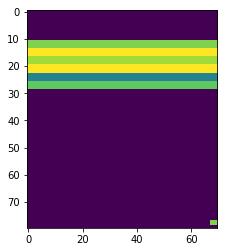

In [44]:
show(env, agent, params, 100, width=80, height=70, greedy=False)